In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# %load_ext autoreload
# %autoreload 2

In [ ]:
df = xr.open_dataset('/g/data/w28/nr4680/rainfall_AC_5min.nc')
print(df)

In [4]:
# Annual precipitation for each station in Auckland
import os, numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from netCDF4 import chartostring

# ----------------- Paths & Options -----------------
nc_path     = "/g/data/w28/nr4680/rainfall_AC_5min.nc"
output_dir  = "/g/data/w28/yk8692/nesp_backup/figure"
os.makedirs(output_dir, exist_ok=True)

region_name = "Auckland"        # used in figure/CSV names
drop_years  = [2024, 2025]            # drop incomplete years if desired (edit as needed)

# Optional: spatial filter for Auckland (EDIT if you want a different box)
use_bbox_filter = True
lat_min, lat_max = -37.4, -36.2
lon_min, lon_max = 174.2, 175.6

# Your colormap (reuse)
precip2_17lev_colors = [
    (255/255,255/255,255/255),(235/255,246/255,255/255),(214/255,226/255,255/255),
    (181/255,201/255,255/255),(142/255,178/255,255/255),(127/255,150/255,255/255),
    (114/255,133/255,248/255),(99/255,112/255,248/255),(0/255,158/255,30/255),
    (60/255,188/255,61/255),(179/255,209/255,110/255),(185/255,249/255,110/255),
    (255/255,249/255,19/255),(255/255,163/255,9/255),(229/255,0/255,0/255),
    (189/255,0/255,0/255),(129/255,0/255,0/255),(0/255,0/255,0/255)
]
precip2_17lev = LinearSegmentedColormap.from_list('precip2_17lev', precip2_17lev_colors)

# ----------------- Helpers -----------------
def fixed_len_char_to_str_list(da):
    arr = da.load().values  # get out of dask for string ops

    # common case: (site, strlen) of bytes/unicode
    if arr.ndim == 2:
        out = []
        for row in arr:
            # row may be bytes (S1) or unicode (U1)
            s = ''.join(
                ch.decode('utf-8', 'ignore') if isinstance(ch, (bytes, bytearray)) else str(ch)
                for ch in row
            )
            out.append(s.replace('\x00', '').strip())
        return out

    # 1-D already strings
    if arr.ndim == 1 and arr.dtype.kind in {'U','S','O'}:
        return [str(s).replace('\x00','').strip() for s in arr]

    # fallback
    return [str(x).replace('\x00','').strip() for x in np.atleast_1d(arr)]

def build_station_labels(ds):
    # prefer name, else id, else site_#
    site_names = None
    site_ids   = None
    if 'site_name' in ds.variables:
        try:
            site_names = fixed_len_char_to_str_list(ds['site_name'])
        except Exception:
            site_names = None
    if 'site_id' in ds.variables:
        try:
            site_ids = fixed_len_char_to_str_list(ds['site_id'])
        except Exception:
            site_ids = None

    nsite = ds.sizes.get('site', 0)

    if site_names and site_ids:
        labels = np.array([f"{sid} | {name}".strip() for sid, name in zip(site_ids, site_names)], dtype=object)
    elif site_names:
        labels = np.array(site_names, dtype=object)
    elif site_ids:
        labels = np.array(site_ids, dtype=object)
    else:
        labels = np.array([f"site_{i}" for i in range(nsite)], dtype=object)

    return labels  # always a NumPy array


def plot_heatmap(df, title_tag):
    if df.empty:
        print("No data to plot.")
        return None
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(df, cmap=precip2_17lev, linewidths=0.5, cbar_kws={"label":"Annual Precipitation (mm)"})
    plt.title(f"Annual Precipitation - {title_tag}", fontsize=14, fontweight='bold')
    plt.xlabel("Year"); plt.ylabel("Station")
    plt.xticks(rotation=45, ha='right')
    out_path = os.path.join(output_dir, f"annual_P_{title_tag.replace(' ','_')}.jpg")
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved {out_path}")
    return out_path

# ----------------- Load & Compute -----------------
# Use chunks on time to keep memory reasonable (2.5M timesteps)
ds = xr.open_dataset(nc_path, chunks={"time": 20000}, decode_times=True)

# Station metadata
station_labels = build_station_labels(ds)

# robust selection of labels
labels_idx     = pd.Index(station_labels, dtype=object)
chosen_labels  = labels_idx.take(site_sel)  # same order as your site selection

# annual sums
annual = ra.groupby("time.year").sum(dim="time").compute()  # dims: (year, site)

# attach human-readable labels to the 'site' coord
annual = annual.assign_coords(site=("site", chosen_labels))

# now convert to a tidy DF: rows=station, cols=year (no need to transpose NumPy manually)
ann_df = annual.transpose("site", "year").to_pandas()

# drop incomplete/unwanted years
for yy in drop_years:
    if yy in ann_df.columns:
        ann_df = ann_df.drop(columns=[yy])

# Sort stations nicely (optional)
ann_df = ann_df.sort_index()

# Save table
csv_path = os.path.join(output_dir, f"annual_P_{region_name.replace(' ','_')}.csv")
ann_df.to_csv(csv_path)
print(f"Saved {csv_path}")

# Plot
fig_path = plot_heatmap(ann_df, f"{region_name} ({len(site_sel)} stations)")

# Quick summary
print("Summary:")
print(f"  Years: {ann_df.columns.min()}–{ann_df.columns.max()}  (dropped: {drop_years})")
print(f"  Stations: {ann_df.shape[0]}")
print(f"  Figure: {fig_path}")
print(f"  CSV:    {csv_path}")

Saved /g/data/w28/yk8692/nesp_backup/figure/annual_P_Auckland.csv
Saved /g/data/w28/yk8692/nesp_backup/figure/annual_P_Auckland_(90_stations).jpg
Summary:
  Years: 2000–2023  (dropped: [2024, 2025])
  Stations: 90
  Figure: /g/data/w28/yk8692/nesp_backup/figure/annual_P_Auckland_(90_stations).jpg
  CSV:    /g/data/w28/yk8692/nesp_backup/figure/annual_P_Auckland.csv


In [1]:
# Resampling 5 mins to 10 mins and 1-hour
import os
import numpy as np
import pandas as pd
import xarray as xr

# ----------------- Config -----------------
nc_path     = "/g/data/w28/nr4680/rainfall_AC_5min.nc"
out_dir     = "/g/data/w28/yk8692/nesp_backup/nz_outputs"
region_name = "Auckland"

# Auckland bbox (edit if needed). Set use_bbox=False to take all NZ sites.
use_bbox   = True
lat_min, lat_max = -37.4, -36.2
lon_min, lon_max = 174.2, 175.6

# Output files
os.makedirs(out_dir, exist_ok=True)
nc_out  = os.path.join(out_dir, f"{region_name}_rainfall_10min_1h.nc")
csv_out = os.path.join(out_dir, f"{region_name}_site_metadata.csv")

# Compression
comp = dict(zlib=True, complevel=4)

# ----------------- Helpers -----------------
def fixed_len_char_to_str_list(da):
    """Convert CF-style char array (site, strlen) -> list[str]."""
    arr = da.load().values  # bring to memory for simple, robust string ops
    if arr.ndim == 2:
        out = []
        for row in arr:
            s = ''.join(ch.decode('utf-8','ignore') if isinstance(ch,(bytes,bytearray)) else str(ch)
                        for ch in row).replace('\x00','').strip()
            out.append(s)
        return out
    if arr.ndim == 1 and arr.dtype.kind in {'U','S','O'}:
        return [str(s).replace('\x00','').strip() for s in arr]
    return [str(x).replace('\x00','').strip() for x in np.atleast_1d(arr)]

def expected_count_per_bin(time, freq_str: str) -> int:
    """Infer native dt from data and return expected #samples per resample bin."""
    # robust dt: median of diffs
    diffs = pd.to_timedelta(pd.Series(time.diff("time").dropna("time").values))
    base = diffs.median()  # pandas Timedelta
    target = pd.to_timedelta(freq_str)
    # Guard: avoid divide-by-zero for weird files
    if base <= pd.Timedelta(0):
        return None
    return int(round(target / base))

# ----------------- Load -----------------
ds = xr.open_dataset(nc_path, chunks={"time": 100_000}, decode_times=True)

# Site metadata
site_ids   = fixed_len_char_to_str_list(ds['site_id'])   if 'site_id'   in ds.variables else None
site_names = fixed_len_char_to_str_list(ds['site_name']) if 'site_name' in ds.variables else None
lats = ds['latitude'].values
lons = ds['longitude'].values
nsite = ds.sizes.get('site', len(lats))

labels = None
if site_ids is not None and site_names is not None:
    labels = np.array([f"{sid} | {nm}".strip() for sid, nm in zip(site_ids, site_names)], dtype=object)
elif site_names is not None:
    labels = np.array(site_names, dtype=object)
elif site_ids is not None:
    labels = np.array(site_ids, dtype=object)
else:
    labels = np.array([f"site_{i}" for i in range(nsite)], dtype=object)

# ----------------- Select region -----------------
if use_bbox:
    mask = (lats >= lat_min) & (lats <= lat_max) & (lons >= lon_min) & (lons <= lon_max)
    if mask.sum() == 0:
        print("WARNING: bbox kept 0 stations; using all sites instead.")
        mask = np.ones_like(lats, dtype=bool)
else:
    mask = np.ones_like(lats, dtype=bool)

sel_idx = np.where(mask)[0]
print(f"Selected {len(sel_idx)} of {nsite} sites.")

# Subset rainfall
ra = ds['rainfall_amount'].isel(site=sel_idx)

# QC: negatives -> 0; extremely large spikes optional clip (comment out if not desired)
ra = ra.where(ra >= 0, 0)
ra = ra.where(ra <= 50, np.nan)  # uncomment if you want to drop unrealistically large 5-min totals

# ----------------- Resample (complete bins only) -----------------
# Infer native dt to set min_count correctly
exp_10m = expected_count_per_bin(ra['time'], '10min')  # likely 2
exp_1h  = expected_count_per_bin(ra['time'], '1h')     # likely 12
print(f"Expected counts per bin: 10min={exp_10m}, 1H={exp_1h}")

# 10-min totals (require full bin)
rain_10min = ra.resample(time='10min').sum(min_count=exp_10m)
rain_10min = rain_10min.rename("rainfall_amount_10min")
rain_10min.attrs.update({
    "long_name": "Rainfall 10-minute total",
    "units": "mm",
    "cell_methods": "time: sum (10min)",
    "note": "Sum of native intervals; bins with insufficient samples are NaN."
})

# 1-hour totals (require full bin)
rain_1h = ra.resample(time='1h').sum(min_count=exp_1h)
rain_1h = rain_1h.rename("rainfall_amount_1h")
rain_1h.attrs.update({
    "long_name": "Rainfall hourly total",
    "units": "mm",
    "cell_methods": "time: sum (1H)",
    "note": "Sum of native intervals; bins with insufficient samples are NaN."
})

# ----------------- Package outputs -----------------
# Attach metadata variables for selected sites
# ----------------- Package outputs (fixed) -----------------
lat_sel = xr.DataArray(lats[sel_idx], dims=("site",), name="latitude")
lon_sel = xr.DataArray(lons[sel_idx], dims=("site",), name="longitude")
lab_sel = xr.DataArray(labels[sel_idx].astype(str), dims=("site",), name="site_label")

# Build dataset without forcing a single top-level 'time'
ds_out = xr.Dataset(
    data_vars=dict(
        rainfall_amount_10min=rain_10min,   # has its own time coord (10min)
        rainfall_amount_1h=rain_1h,         # has its own time coord (1H)
        latitude=lat_sel,
        longitude=lon_sel,
        site_label=lab_sel,                  # vlen strings; do NOT compress
    ),
    coords=dict(
        site=np.arange(len(sel_idx), dtype=np.int32),
    ),
    attrs=dict(
        source_file=nc_path,
        region=region_name,
        processing="Resampled from 5-minute rainfall to 10-minute and hourly totals with full-bin requirement",
    ),
)

# Compression only for numeric vars (strings cannot be compressed)
comp = dict(zlib=True, complevel=4)
encoding = {
    "rainfall_amount_10min": {**comp, "dtype": "f4"},
    "rainfall_amount_1h":    {**comp, "dtype": "f4"},
    "latitude":              {**comp, "dtype": "f4"},
    "longitude":             {**comp, "dtype": "f4"},
    # 'site_label' intentionally omitted (vlen string; no compression)
}

print(f"Writing NetCDF -> {nc_out}")
ds_out.to_netcdf(nc_out, format="NETCDF4", encoding=encoding)

# Also write site metadata CSV (handy for browsing)
meta = pd.DataFrame({
    "site_index": np.arange(len(sel_idx)),
    "site_label": labels[sel_idx],
    "latitude":   lats[sel_idx],
    "longitude":  lons[sel_idx],
})
meta.to_csv(csv_out, index=False)
print(f"Wrote site metadata CSV -> {csv_out}")

Selected 90 of 90 sites.
Expected counts per bin: 10min=2, 1H=12
Writing NetCDF -> /g/data/w28/yk8692/nesp_backup/nz_outputs/Auckland_rainfall_10min_1h.nc
Wrote site metadata CSV -> /g/data/w28/yk8692/nesp_backup/nz_outputs/Auckland_site_metadata.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import xarray as xr

# ----------------- Config -----------------
nc_in       = "/g/data/w28/yk8692/nesp_backup/nz_outputs/Auckland_rainfall_10min_1h.nc"
out_csv     = "/g/data/w28/yk8692/nesp_backup/figure/Auckland_top10_extreme_events_ranked_with_latlon.csv"
top_n       = 10
exclude_zero_for_threshold = True  # match your previous behavior

# ----------------- Load -----------------
ds = xr.open_dataset(nc_in, chunks={"time": 200_000})

da10 = ds["rainfall_amount_10min"]  # (time, site)
da1h = ds["rainfall_amount_1h"]     # (time, site)
site_labels = ds["site_label"].values.astype(str)
lats  = ds["latitude"].values
lons  = ds["longitude"].values
nsite = da10.sizes["site"]

# ----------------- Global 1h 99th percentile (region-wide) -----------------
da1h_for_q = da1h
if exclude_zero_for_threshold:
    da1h_for_q = da1h_for_q.where(da1h_for_q > 0)

global_99p = float(da1h_for_q.quantile(0.99, dim=("time","site"), skipna=True).compute())
print(f"Global 1h 99th percentile: {global_99p:.2f} mm")

# ----------------- Per-site daily maxima & timestamps -----------------
rows = []

for s in range(nsite):
    # 10-min series for this site -> pandas Series
    ser10 = da10.isel(site=s).to_series()  # index: time (ns), values: mm
    ser1h = da1h.isel(site=s).to_series()

    # Drop all-NaN sites early
    if ser10.notna().sum() == 0:
        continue

    # Daily maxima and their timestamps
    # idxmax returns the first occurrence of the max within the day
    def safe_idxmax(s: pd.Series):
        s = s.dropna()
        return s.idxmax() if not s.empty else pd.NaT
    
    for s in range(nsite):
        ser10 = da10.isel(site=s).to_series()
        ser1h = da1h.isel(site=s).to_series()
    
        if ser10.notna().sum() == 0:
            continue
    
        # ---- 10-min daily max + timestamp ----
        df10 = ser10.to_frame('p10')
        df10['Date'] = df10.index.normalize()  # midnight of day
        daily10_max  = df10.groupby('Date')['p10'].max()
        daily10_tmax = df10.groupby('Date')['p10'].apply(safe_idxmax)
    
        # ---- 1-hour daily max + timestamp ----
        df1h = ser1h.to_frame('p1h')
        df1h['Date'] = df1h.index.normalize()
        daily1h_max  = df1h.groupby('Date')['p1h'].max()
        daily1h_tmax = df1h.groupby('Date')['p1h'].apply(safe_idxmax)
    
        # ---- Merge & annotate ----
        site_df = pd.DataFrame({
            "Date": daily10_max.index,
            "Daily_Max_10min": daily10_max.values,
            "Datetime_10min_Max": daily10_tmax.values,
        }).merge(
            pd.DataFrame({
                "Date": daily1h_max.index,
                "Daily_Max_1h": daily1h_max.values,
                "Datetime_1h_Max": daily1h_tmax.values,
            }),
            on="Date",
            how="left",
        )
    
        site_df = site_df.dropna(subset=["Daily_Max_10min"]).copy()
        site_df["Station"]   = site_labels[s]
        site_df["Latitude"]  = lats[s]
        site_df["Longitude"] = lons[s]
        site_df["Above_99p_1h"] = np.where(site_df["Daily_Max_1h"] > global_99p, "Y", "N")
    
        rows.append(site_df)

if not rows:
    raise RuntimeError("No station had valid 10-min maxima—check inputs.")

all_df = pd.concat(rows, ignore_index=True)

# ----------------- Select Top N by unique date -----------------
# Sort by 10-min daily max descending
all_df_sorted = all_df.sort_values("Daily_Max_10min", ascending=False)

# Pick the top N unique dates (like your previous logic)
picked = []
seen_dates = set()
for _, r in all_df_sorted.iterrows():
    d = pd.to_datetime(r["Date"]).date()
    if d not in seen_dates:
        picked.append(r)
        seen_dates.add(d)
        if len(seen_dates) >= top_n:
            break

top_df = pd.DataFrame(picked)

# Rank by the per-date maximum of 10-min value (descending)
top_df["DateOnly"] = pd.to_datetime(top_df["Date"]).dt.date
rank_map = {
    date: rank + 1
    for rank, date in enumerate(
        sorted(
            top_df["DateOnly"].unique(),
            key=lambda d: top_df.loc[top_df["DateOnly"] == d, "Daily_Max_10min"].max(),
            reverse=True,
        )
    )
}
top_df["Rank"] = top_df["DateOnly"].map(rank_map)

# Final tidy output
final_cols = [
    "Rank", "Date", "Station", "Latitude", "Longitude",
    "Daily_Max_10min", "Datetime_10min_Max",
    "Daily_Max_1h", "Datetime_1h_Max", "Above_99p_1h"
]
top_df = top_df.sort_values(["Rank", "Daily_Max_10min"], ascending=[True, False])[final_cols].reset_index(drop=True)

# If you only want rows where 1h >= 99th (like your earlier filter), uncomment:
# top_df = top_df[top_df["Above_99p_1h"] == "Y"].copy().reset_index(drop=True)

# ----------------- Save -----------------
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
top_df.to_csv(out_csv, index=False)
print(top_df)
print(f"\nSaved: {out_csv}")

/jobfs/150615952.gadi-pbs/ipykernel_705058/3110228727.py:13: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 200000. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(nc_in, chunks={"time": 200_000})


Global 1h 99th percentile: 7.57 mm


In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from dask import compute
# OPTIONAL: scale out on a compute node (comment out if on login node)
USE_DASK_DISTRIBUTED = True
if USE_DASK_DISTRIBUTED:
    try:
        from dask.distributed import Client, LocalCluster
        client = Client(LocalCluster(n_workers=7, threads_per_worker=1))
        print(client)
    except Exception as e:
        print("Dask distributed not started:", e)

# -------- Config --------
nc_in   = "/g/data/w28/yk8692/nesp_backup/nz_outputs/Auckland_rainfall_10min_1h.nc"
out_csv = "/g/data/w28/yk8692/nesp_backup/figure/Auckland_top10_extreme_events_ranked_with_latlon.csv"
top_n   = 10
exclude_zero_for_threshold = True

# -------- Load (let xarray pick stored chunking) --------
ds   = xr.open_dataset(nc_in, chunks="auto")
da10 = ds["rainfall_amount_10min"]   # (time, site)
da1h = ds["rainfall_amount_1h"]      # (time, site)

labels = ds["site_label"].values.astype(str)
lats   = ds["latitude"].values
lons   = ds["longitude"].values

# -------- Global 1h 99th percentile (region-wide) --------
da1h_for_q = da1h.where(da1h > 0) if exclude_zero_for_threshold else da1h
global_99p = float(da1h_for_q.quantile(0.99, dim=("time","site"), skipna=True).compute())
print(f"Global 1h 99th percentile: {global_99p:.2f} mm")

# -------- Daily maxima (vectorized; fast) --------
# values per (day, site)
d10_max = da10.resample(time="1D").max()   # (day, site)
d1h_max = da1h.resample(time="1D").max()   # (day, site)

# after computing d10_max and d1h_max:
d10_max = d10_max.persist()
d1h_max = d1h_max.persist()

# per day, which site had the largest 10-min max? and what value?
day_best_site = d10_max.argmax("site")   # (day)
day_best_val  = d10_max.max("site")      # (day)
print(f"Compute small daily arrays")
# materialize small daily arrays
day_best_site, day_best_val = compute(day_best_site, day_best_val)
print(f"Compute small daily arrays done")
# -------- Pick Top-N days by 10-min max (unique days) --------
vals  = day_best_val.values
times = day_best_val["time"].values
k = min(top_n, vals.size)
top_unsorted = np.argpartition(vals, -k)[-k:]
top_sorted   = top_unsorted[np.argsort(vals[top_unsorted])[::-1]]  # desc
top_days  = times[top_sorted]
top_sites = day_best_site.values[top_sorted]
print(f"Start loop")
# -------- For ONLY those Top-N (day, site), fetch timestamps-of-max --------
rows = []
for day, s in zip(top_days, top_sites):
    day = np.datetime64(day, "ns")
    day_end = day + np.timedelta64(1, "D")

    # values for that (day, site)  — compute before item()
    v10 = d10_max.sel(time=day, site=int(s)).compute().item()
    v1h = d1h_max.sel(time=day, site=int(s)).compute().item()
    
    # tiny slices to recover timestamps (still cheap I/O)
    ser10 = da10.sel(site=int(s), time=slice(day, day + np.timedelta64(1, "D"))).to_series()
    t10   = pd.to_datetime(ser10.idxmax()) if ser10.notna().any() else pd.NaT
    
    ser1h = da1h.sel(site=int(s), time=slice(day, day + np.timedelta64(1, "D"))).to_series()
    t1h   = pd.to_datetime(ser1h.idxmax()) if ser1h.notna().any() else pd.NaT

    rows.append({
        "Date":               pd.to_datetime(day).normalize(),
        "Station":            str(labels[int(s)]),
        "Latitude":           float(lats[int(s)]),
        "Longitude":          float(lons[int(s)]),
        "Daily_Max_10min":    float(v10) if np.isfinite(v10) else np.nan,
        "Datetime_10min_Max": t10,
        "Daily_Max_1h":       float(v1h) if np.isfinite(v1h) else np.nan,
        "Datetime_1h_Max":    t1h,
    })

top_df = pd.DataFrame(rows)
top_df["Above_99p_1h"] = np.where(top_df["Daily_Max_1h"] > global_99p, "Y", "N")
top_df.insert(0, "Rank", np.arange(1, len(top_df)+1))

final_cols = [
    "Rank", "Date", "Station", "Latitude", "Longitude",
    "Daily_Max_10min", "Datetime_10min_Max",
    "Daily_Max_1h", "Datetime_1h_Max", "Above_99p_1h"
]
top_df = top_df[final_cols]
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
top_df.to_csv(out_csv, index=False)
print(top_df)
print(f"\nSaved: {out_csv}")


<Client: 'tcp://127.0.0.1:33321' processes=7 threads=7, memory=32.00 GiB>
Global 1h 99th percentile: 7.57 mm


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Compute small daily arrays
Compute small daily arrays done
Start loop
   Rank       Date                                            Station  \
0     1 2011-03-06         b'647618' | b'Albany at Albany Heights Rd'   
1     2 2016-07-07                b'643715' | b'Omaha at Golf Course'   
2     3 2016-09-25                      b'649519' | b'Lower Huia Dam'   
3     4 2022-03-23            b'643713' | b'Tamahunga at Quintals Rd'   
4     5 2004-01-31  b'648614' | b'Harmel Rd Waitakere City Council...   
5     6 2013-04-20         b'659401' | b'Matiatia Bay Waiheke Island'   
6     7 2023-01-27              b'649636' | b'Oratia Cemetery Oratia'   
7     8 2016-01-31              b'741813' | b'Whangamaire at Culvert'   
8     9 2012-12-05      b'648613' | b'Substation at Lincoln Park Ave'   
9    10 2022-11-19             b'649818' | b'Anns Ck at ACC Abattoir'   

    Latitude   Longitude  Daily_Max_10min  Datetime_10min_Max  Daily_Max_1h  \
0 -36.709919  174.691010        33.200001 2011-

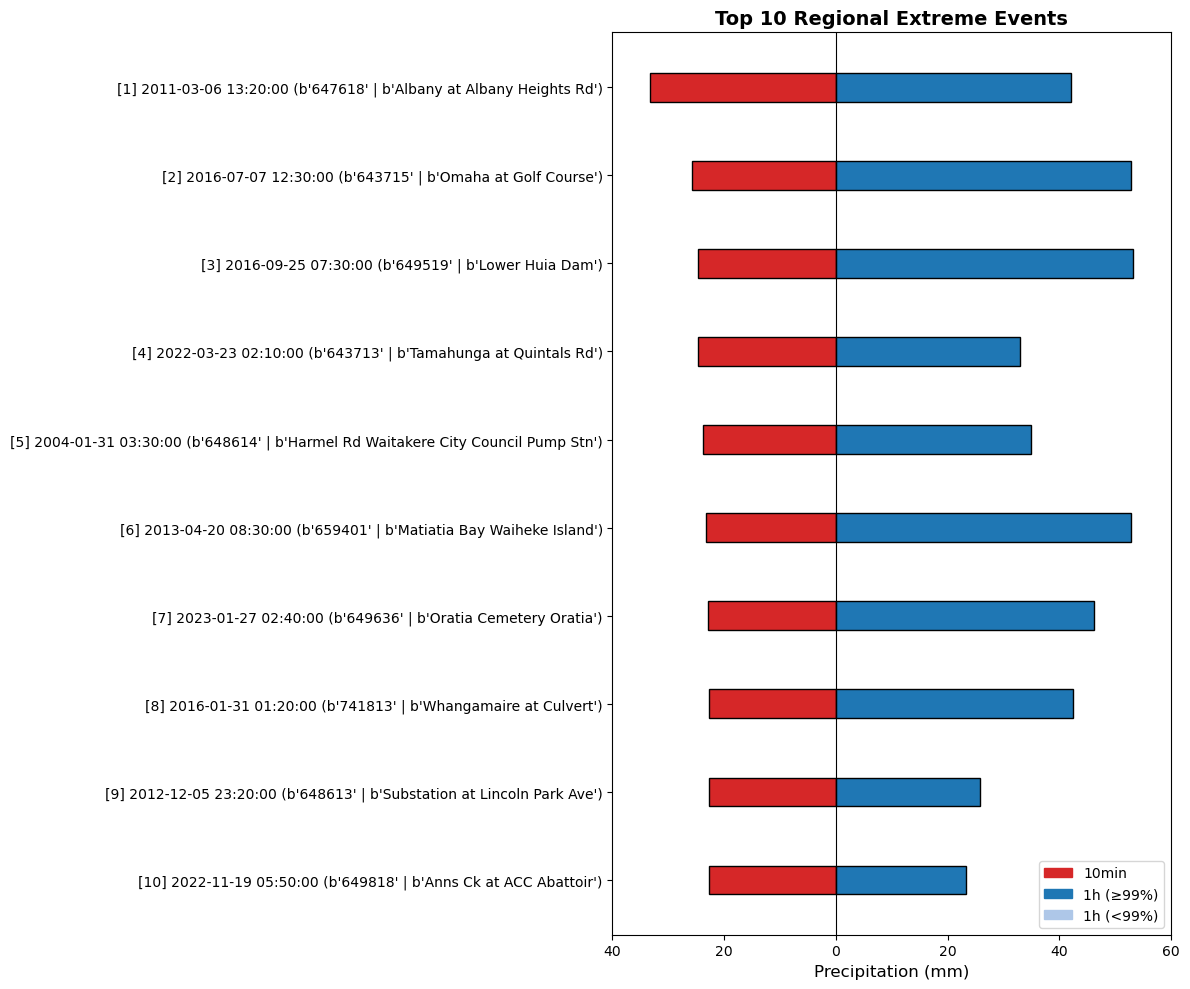

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load your CSV with date parsing
# Define the directory path
region_name = "Auckland"

# --- File and Path Setup ---
shape_path = "/g/data/w28/yk8692/nesp_backup"

file_path = f'{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv'
df = pd.read_csv(file_path, parse_dates=["Datetime_10min_Max", "Datetime_1h_Max"])

# Sort by rank and datetime
df = df.sort_values(["Rank", "Datetime_10min_Max"])

# Plot setup
fig, ax = plt.subplots(figsize=(12, 10))
y_labels = []
y_pos = []

# Bar styling
bar_height = 0.8
rank_gap = 1.5  # vertical space between rank groups
color_10min = "#d62728"
color_1h_above = "#1f77b4"
color_1h_below = "#aec7e8"

# Plot bars grouped by rank
y = 0
last_rank = None

for i, row in df.iterrows():
    if last_rank is not None and row["Rank"] != last_rank:
        y += rank_gap  # add gap between ranks

    # Label and position
    label = f"{[row['Rank']]} {row['Datetime_10min_Max']} ({row['Station']})"
    y_labels.append(label)
    y_pos.append(y)

    # 10-min bar (left side)
    ax.barh(
        y, -row["Daily_Max_10min"],
        color=color_10min,
        height=bar_height,
        edgecolor='black'
    )

    # 1-h bar (right side)
    color_1h = color_1h_above if row["Above_99p_1h"] == "Y" else color_1h_below
    ax.barh(
        y, row["Daily_Max_1h"],
        color=color_1h,
        height=bar_height,
        edgecolor='black'
    )

    y += 1
    last_rank = row["Rank"]

# Final aesthetics
ax.axvline(0, color="black", linewidth=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=10)
ax.set_xlabel("Precipitation (mm)", fontsize=12)
ax.set_title("Top 10 Regional Extreme Events", fontsize=14, weight='bold')
ax.tick_params(axis='x', labelsize=10)
ax.invert_yaxis()

# Custom legend
handles = [
    mpatches.Patch(color=color_10min, label="10min"),
    mpatches.Patch(color=color_1h_above, label="1h (≥99%)"),
    mpatches.Patch(color=color_1h_below, label="1h (<99%)")
]
ax.legend(handles=handles, loc='lower right', fontsize=10)

# Set symmetric x-ticks and show absolute values
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels([str(abs(int(x))) for x in xticks])

# Subtitles
xlim = ax.get_xlim()
ymax = max(y_pos) - 23.5
# ax.text(xlim[0] + 27, ymax, "10min", fontsize=13, weight='bold', color=color_10min, ha='left', va='center')
# ax.text(xlim[1] - 93, ymax, "1h", fontsize=13, weight='bold', color=color_1h_above, ha='right', va='center')

plt.tight_layout()
plt.savefig(f'{shape_path}/figure/top_10_groupbar_{region_name}.png', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


In [3]:
summary_file = f"{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
# Make a copy so you don’t clobber your original
out = df.copy()

# ✅ Filter to keep only rows where 1h precipitation is above 99th percentile
out = out[out['Above_99p_1h'] == 'Y'].copy()

# 1) Add “Sr. no.” as a 1-based index
out.insert(0, 'Sr. no.', range(1, len(out) + 1))

# 2) Rename columns to match your desired headers
out = out.rename(columns={
    'Datetime_10min_Max':    'Time of 10min P',
    'Daily_Max_10min':       'Precipitation at 10min',
    'Datetime_1h_Max':       'Time of 1hr P',
    'Daily_Max_1h':          'Precipitation at 1hr',
    'Station':               'station name'
})

# 3) Select and order the columns exactly how you want
out = out[[
    'Sr. no.',
    'Time of 10min P',
    'Precipitation at 10min',
    'Time of 1hr P',
    'Precipitation at 1hr',
    'station name',
    'Longitude',
    'Latitude'
]]

# 4) Save to CSV
output_file = f'{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon_formatted.csv'
out.to_csv(output_file, index=False)

# 5) (Optional) print to verify
print(out.head(10))

   Sr. no.     Time of 10min P  Precipitation at 10min        Time of 1hr P  \
0        1 2011-03-06 13:20:00               33.200001  2011-03-06 13:00:00   
1        2 2016-07-07 12:30:00               25.805000  2016-07-07 12:00:00   
2        3 2016-09-25 07:30:00               24.709999  2016-09-25 07:00:00   
3        4 2022-03-23 02:10:00               24.656799  2022-03-23 02:00:00   
4        5 2004-01-31 03:30:00               23.810101  2004-01-31 03:00:00   
5        6 2013-04-20 08:30:00               23.244499  2013-04-20 08:00:00   
6        7 2023-01-27 02:40:00               22.836000  2023-01-27 02:00:00   
7        8 2016-01-31 01:20:00               22.808599  2016-01-31 01:00:00   
8        9 2012-12-05 23:20:00               22.763300  2012-12-05 23:00:00   
9       10 2022-11-19 05:50:00               22.741800  2022-11-19 05:00:00   

   Precipitation at 1hr                                       station name  \
0             42.000000         b'647618' | b'Albany

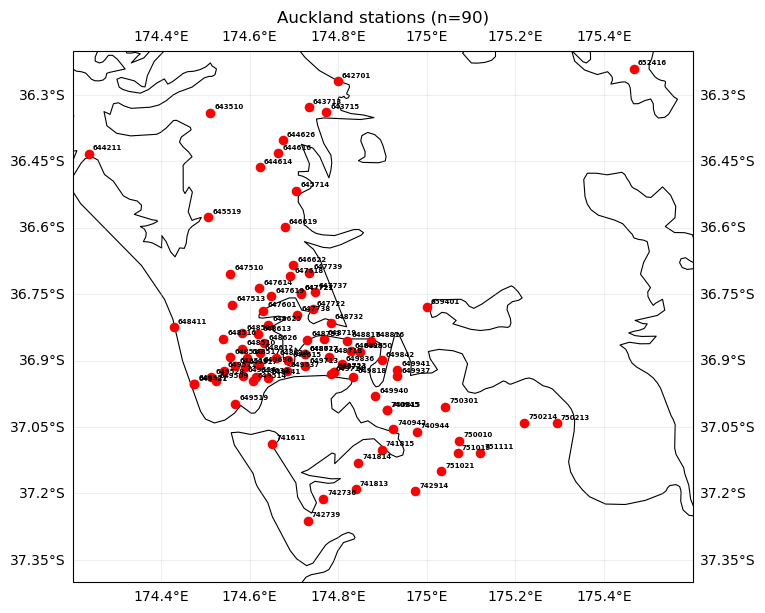

Also wrote coastline version.
Plotted 90 stations.
Figure: /g/data/w28/yk8692/nesp_backup/figure/Auckland_stations_map_numbers.png
CSV:    /g/data/w28/yk8692/nesp_backup/figure/Auckland_stations_plotted.csv


In [11]:
import os, re
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# ---------------- Config ----------------
nc_in   = "/g/data/w28/yk8692/nesp_backup/nz_outputs/Auckland_rainfall_10min_1h.nc"
out_dir = "/g/data/w28/yk8692/nesp_backup/figure"
os.makedirs(out_dir, exist_ok=True)
png_out = os.path.join(out_dir, "Auckland_stations_map_numbers.png")
csv_out = os.path.join(out_dir, "Auckland_stations_plotted.csv")

# Auckland bbox (adjust if needed)
lat_min, lat_max = -37.4, -36.2
lon_min, lon_max = 174.2, 175.6

# Exclusions by exact station number
exclude_ids = {"64"}

# ---------------- Load station metadata ----------------
ds   = xr.open_dataset(nc_in)
lats = ds["latitude"].values
lons = ds["longitude"].values
labels = ds["site_label"].values.astype(str) if "site_label" in ds else np.array([f"site_{i}" for i in range(len(lats))])

def parse_station_number(label: str) -> str:
    # If "id | name" → take left; else extract leading digits
    left = label.split("|", 1)[0].strip()
    m = re.search(r"\d+", left)
    return m.group(0) if m else ""

station_nums = np.array([parse_station_number(s) for s in labels], dtype=object)

df = pd.DataFrame({
    "station_number": station_nums,
    "site_label": labels,
    "lat": lats,
    "lon": lons,
})

# Filter to Auckland bbox and exclude specific IDs
df = df[(df["lat"] >= lat_min) & (df["lat"] <= lat_max) &
        (df["lon"] >= lon_min) & (df["lon"] <= lon_max)].copy()
df = df[~df["station_number"].isin(exclude_ids)].copy()

# ---------------- Plot ----------------
# fig, ax = plt.subplots(figsize=(8, 8))

# # Simple background: just the bounding box & grid (keeps it dependency-free)
# ax.add_patch(plt.Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min,
#                            fill=False, edgecolor="black", linewidth=1.0, zorder=0))

# Optional: coastline with Cartopy (may require cached Natural Earth files)
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.8, zorder=1)
    ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3)
    ax.scatter(df["lon"], df["lat"], s=35, c="red", transform=ccrs.PlateCarree(), zorder=2)
    for _, r in df.iterrows():
        if r["station_number"]:
            ax.annotate(str(r["station_number"]), (r["lon"], r["lat"]),
                        xytext=(3, 3), textcoords="offset points",
                        fontsize=5, fontweight="bold", transform=ccrs.PlateCarree(), zorder=3)
    plt.title(f"Auckland stations (n={len(df)})")
    plt.savefig(png_out.replace(".png", "_coast.png"), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print("Also wrote coastline version.")
except Exception as e:
    print("Cartopy coastline not available:", e)
    
# # Scatter points
# ax.scatter(df["lon"], df["lat"], s=35, c="red", zorder=2)

# # Label with station numbers (e.g., 2701); skip if empty
# for _, r in df.iterrows():
#     txt = str(r["station_number"]) if r["station_number"] else ""
#     ax.annotate(txt, (r["lon"], r["lat"]), xytext=(3, 3),
#                 textcoords="offset points", fontsize=8, fontweight="bold",
#                 color="black", zorder=3)

# ax.set_title(f"Auckland stations (n={len(df)})", fontsize=14)
# ax.set_xlim(lon_min, lon_max)
# ax.set_ylim(lat_min, lat_max)
# ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
# ax.grid(True, alpha=0.3, linewidth=0.5)


# plt.tight_layout()
# plt.show()
# plt.savefig(png_out, dpi=300, bbox_inches="tight")
# plt.close()

# Save CSV of plotted stations
df[["station_number", "site_label", "lat", "lon"]].to_csv(csv_out, index=False)

print(f"Plotted {len(df)} stations.")
print(f"Figure: {png_out}")
print(f"CSV:    {csv_out}")
